# **BackToTheAttention**

This project aims to use the attention mechanism for time series prediction. As time series data needs special handling and I had no experience in doing so, I decided to use one of the most beautiful, influential, and genius mechanisms ever to combine it with stock prediction. I will try to predict stocks for Pinterest (ticker: `"PINS"`), but one can reuse this code for any stock.

This notebook, as well as its successor: `inference.ipynb`, follows a **code-first** structure, meaning I first implemented the code under the `src/` directory and then simply copy-pasted the code here, so some aspects might have been implemented differently if the project were notebook-oriented.

**Note 1**: Since this script uses Yahoo Finance's API to get the stock data, it needs an internet connection to run. Although installing the libraries also requires an internet connection, that might not be too project-specific.

**Note 2:** The notebooks save and load models/plots from the `notebooks/models/` directory, which is a simple way to prevent models trained here from overwriting models trained via scripts. This wouldn’t be a problem if the results were reproducible, but since we fetch the latest data, they are not.

First, let's start with library installation, imports, and logger setup:

In [54]:
!pip install scikit-learn statsmodels torch yfinance
import joblib
import logging
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import torch
import torch.nn as nn
import yfinance as yf

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.arima.model import ARIMA
from torch.utils.data import DataLoader, TensorDataset

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s', datefmt='%d/%m/%Y %H:%M:%S')
logger = logging.getLogger("BackToTheTrainLogger (Train)")

## **Data Acquisition**

We have to define a method for acquiring the data for any stock and custom period:

In [55]:
def get_data(ticker: str, period: str = "3y") -> pd.DataFrame:
    data = yf.Ticker(ticker)
    df = data.history(period=period)  # only the latest 'period' stocks
    logger.info("HISTORY:\n%s\n%s", list(df.columns), df.head())  # we want to predict the 'Close' price

    # we don't really care about dividends and stock splits, as they provide no information related to the 'Close' price (most of the time they are 0).
    # I am not a quant, but this is based on my limited knowledge; therefore, we drop those two columns and use the rest for the task.
    df.drop(columns=["Dividends", "Stock Splits"], inplace=True)

    return df

MinMax scaling is necessary for this task because neural network based architectures, including Transformers, train more stably and converge faster when input features are normalized to a consistent range like $[0,1]$ rather than using raw stock prices that can vary widely in magnitude. Large or varying input values can lead to exploding or vanishing gradients during backpropagation, particularly in attention mechanisms where dot products between queries and keys become unbalanced and dominate the softmax unfairly. Scaling also ensures that the model's learned patterns are driven by relative changes in price rather than absolute levels, which is especially helpful for financial time series.

I fit `MinMaxScaler` (0 to 1) ONLY on training portion to prevent data leakage.
$$x_\text{scaled} = \frac{x - \text{train}_{\text{min}}}{\text{train}_{\text{max}} - \text{train}_{\text{min}}}$$

In [56]:
def minmax_scale(series: np.ndarray, train_ratio: float = 0.8) -> tuple[np.ndarray, np.ndarray, MinMaxScaler]:
    n = len(series)
    split_idx = int(n * train_ratio)  # chronological split point
    train_series = series[:split_idx]
    test_series = series[split_idx:]

    # fit scaler only on train data
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler.fit(train_series)
    train_scaled = scaler.transform(train_series)
    test_scaled = scaler.transform(test_series)

    logger.info("Train scaled shape: %s, Test scaled shape: %s", train_scaled.shape, test_scaled.shape)
    logger.info("Scaler min: %.4f, scale: %.4f", scaler.min_[0], scaler.scale_[0])

    return train_scaled, test_scaled, scaler

Define the `create_windows` (sliding window) method, which for $X_i = [x_{i}, x_{i + 1}, \cdots, x_{i + L - 1}] \in \mathbb{R}^{L \times 1}$ and $y_i = x_{i + L}$ returns $X \in \mathbb{R}^{N \times L \times 1}, y \in \mathbb{R}^{N \times 1}$ where $N =$ `len(scaled_data)`, a.k.a. lookback.

In [57]:
def create_windows(scaled_data: np.ndarray, L: int = 30) -> tuple[np.ndarray, np.ndarray]:
    if len(scaled_data) <= L:
        raise ValueError("Data length %d must be > lookback %d", len(scaled_data), L)

    X, y = [], []
    for i in range(len(scaled_data) - L):
        X.append(scaled_data[i:i + L])
        y.append(scaled_data[i + L])

    X = np.array(X)  # shape: (N, L, 1)
    y = np.array(y).squeeze(-1)  # shape: (N,) for easier loss computation

    logger.info("Created windows -> X shape: %s, y shape: %s", X.shape, y.shape)

    return X, y

before moving on to the architecture, I finally define:

In [58]:
def prepare_datasets(df: pd.DataFrame, L: int = 30, train_ratio: float = 0.8) -> tuple[
    np.ndarray, np.ndarray, np.ndarray, np.ndarray, MinMaxScaler]:
    series = df['Close'].values.reshape(-1, 1)
    train_scaled, test_scaled, scaler = minmax_scale(series, train_ratio=train_ratio)

    # test windows use ONLY past test data (no train leakage)
    X_train, y_train = create_windows(train_scaled, L=L)
    X_test, y_test = create_windows(test_scaled, L=L)

    logger.info("Final datasets ready -> Train samples: %d, Test samples: %d", len(X_train), len(X_test))

    return X_train, y_train, X_test, y_test, scaler

## **Embedding**

I read [the paper about the Rotary Positional Embedding](https://arxiv.org/pdf/2104.09864) in August 2025, and as it is better than simple absolute or relative embeddings, why not use it? RoPE is a mixture of absolute positional embedding, which was introduced in the original ["Attention is All You Need" paper](https://arxiv.org/pdf/1706.03762) (where the base $10000$ comes from), and relative encoding (which is not really efficient to compute, as opposed to absolute and rotary). Because of the latter, I thought it would be a great fit for the time-series data.

In [59]:
class RoPE(nn.Module):
    def __init__(self, dim: int, base: float = 10000.0):
        super().__init__()
        self.dim = dim
        self.base = base

        # precompute frequencies: \theta_i = base^{-2i/dim}
        inv_freq = 1.0 / (base ** (torch.arange(start=0, end=dim, step=2, dtype=torch.float32) / dim))

        # to save as part of a model's persistent state without treating it as a learnable parameter
        self.register_buffer(name="inv_freq", tensor=inv_freq, persistent=True)  # shape: (dim / 2,)

    def forward(self, x: torch.Tensor, seq_len: int) -> torch.Tensor:
        positions = torch.arange(0, seq_len, device=x.device, dtype=self.inv_freq.dtype)  # (seq_len,)
        angles = positions[:, None] * self.inv_freq[None, :]  # (seq_len, dim//2)
        sin, cos = torch.sin(angles), torch.cos(angles)  # (seq_len, dim / 2)
        # expand dims for broadcasting: (seq_len, dim//2) -> (1, seq_len, dim//2)
        sin = sin.unsqueeze(0)
        cos = cos.unsqueeze(0)

        # split the last dimension
        x1 = x[..., : self.dim // 2]  # (B, seq_len, dim / 2)
        x2 = x[..., self.dim // 2:]  # (B, seq_len, dim / 2)
        # Rotation matrix
        rotated_x1 = x1 * cos - x2 * sin
        rotated_x2 = x1 * sin + x2 * cos

        return torch.cat([rotated_x1, rotated_x2], dim=-1)

## **DeLorean + Attention = DeTention**

`DeTentionBlock` is the core repeating unit that applies RoPE-enhanced self-attention and feed-forward processing with residual connections. I won't be repeating what arguments this class takes, as that's obvious, but here is my though process for the architecture:

Apply embedding to the normalized layer, then compute the attention with RoPE-embedded $q$ and $k$ (not $v$!), normalize again and combine with the original input to allow the gradient flow, then use feed-forward neural net to figure out the "final" token.

**Note**: as we use GLU, it requires `ff_hidden_size` to be of even dimension. If you do not want to have such restriction, maybe try replacing GLU with GELU.

In [60]:
class DeTentionBlock(nn.Module):
    def __init__(self, d_model: int, n_heads: int, ff_hidden_size: int = 256, dropout: float = 0.2):
        super().__init__()
        self.d_model = d_model  # must be even and divisible by n_heads
        self.n_heads = n_heads
        self.ff_hidden_size = ff_hidden_size
        self.dropout = dropout

        self.norm1 = nn.LayerNorm(d_model)
        self.rope = RoPE(dim=d_model, base=10000.0)
        self.attention = nn.MultiheadAttention(embed_dim=d_model, num_heads=n_heads, dropout=dropout, batch_first=True)  # makes input (batch, seq, dim) instead of (seq, batch, dim)
        self.norm2 = nn.LayerNorm(d_model)
        self.ff = nn.Sequential(
            nn.Linear(d_model, ff_hidden_size),
            nn.GLU(dim=-1),  # https://arxiv.org/pdf/2002.05202; please, check the last line of section 4 (Conclusions)
            nn.Dropout(dropout),
            nn.Linear(ff_hidden_size // 2, d_model)
        )
        self.dropout_layer = nn.Dropout(dropout)


    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Attention sub-layer with residual connection
        residual = x
        x = self.norm1(x)
        q, k = self.rope(x, seq_len=x.shape[1]), self.rope(x, seq_len=x.shape[1])
        attn_output, _ = self.attention(query=q, key=k, value=x, need_weights=False)  # I do not intend to visualize attention
        x = self.dropout_layer(attn_output) + residual

        # FF sub-layer with residual connection
        residual = x
        x = self.ff(self.norm2(x))
        x = self.dropout_layer(x) + residual

        return x

`DeTention`, which is the complete end-to-end model that handles input projection from raw prices, stacks multiple `DeTention` blocks and produces the final prediction. It has raw stock prices to $\mathbb{R}^{d_\text{model}}$ projection, then uses $k$ `DeTentionBlock`s and optional average pooling for final prediction.

In [61]:
class DeTention(nn.Module):
    def __init__(self, seq_len: int = 30, d_model: int = 64, n_heads: int = 4, n_layers: int = 2, ff_hidden_size: int = 256, dropout: float = 0.2, use_avg_pool: bool = True):
        super().__init__()
        self.seq_len = seq_len
        self.d_model = d_model
        self.use_avg_pool = use_avg_pool

        self.input_proj = nn.Linear(1, d_model)  # 'Close' -> d_model
        self.DeTention_blocks = nn.ModuleList([DeTentionBlock(d_model=d_model, n_heads=n_heads, ff_hidden_size=ff_hidden_size, dropout=dropout) for i in range(n_layers)])
        self.norm = nn.LayerNorm(d_model)
        self.output_head = nn.Linear(d_model, 1)

        # optional global average pooling instead of last token
        if use_avg_pool:
            self.pool = nn.AdaptiveAvgPool1d(output_size=1)  # (B, d_model, L) -> (B, d_model, 1)


    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.input_proj(x)  # (batch_size, seq_len, 1) -> (batch_size, seq_len, d_model)
        for block in self.DeTention_blocks:
            x = block(x)
        x = self.norm(x)

        # pooling or last token
        if self.use_avg_pool:
            x = self.pool(x.transpose(1, 2)).squeeze(-1)  # (B, d_model, L) -> (B, d_model); nn.AdaptiveAvgPool1d expects channel dimension second (like images: N, C, L)
        else:
            x = x[:, -1, :]  # last position

        x = self.output_head(x)  # next price prediction: (batch_size, 1)

        return x.squeeze(dim=-1)  # (batch_size,)

We also have methods for saving and loading the `DeTention` model:

In [62]:
def save_model(model: DeTention, path: str = "models/DeTention.pth") -> None:  # save the entire model (architecture + weights)
    os.makedirs(os.path.dirname(path), exist_ok=True)
    torch.save({
        'state_dict': model.state_dict(),
        'config': {
            'seq_len': model.seq_len,
            'd_model': model.d_model,
            'use_avg_pool': model.use_avg_pool
        }
    }, path)


def load_model(path: str = "models/DeTention.pth", **model_kwargs) -> DeTention:
    if not os.path.exists(path):
        raise FileNotFoundError(f"Model file not found: {path}")

    checkpoint = torch.load(path, map_location=torch.device('cpu'), weights_only=True)
    config = checkpoint.get('config', {})
    config.update(model_kwargs)
    model = DeTention(**config)
    model.load_state_dict(checkpoint['state_dict'])

    return model

## Setup for training

First, let's declare hyperparameters:

In [63]:
ticker = "PINS"
period = "3y"
L = 30
train_ratio = 0.8
batch_size = 32
lr = 1e-4
epochs = 100
patience = 15
d_model = 64
n_heads = 4
n_layers = 2
ff_hidden_size = 256
dropout = 0.2
use_avg_pool = True

best_test_loss = float('inf')
patience_counter = 0
best_path = "models/DeTention_best.pth"
final_path = "models/DeTention.pth"
scaler_path = "models/scaler.pkl"

# enforce divisibility constraints
if d_model % n_heads != 0:
    logger.info("d_model (%d) not divisible by n_heads (%d) -> resetting d_model to 64 and n_head to 4", d_model, n_heads)
    d_model = 64
    n_heads = 4

if ff_hidden_size & 1:
    logger.info("ff_hidden_size (%d) must be even for GLU -> resetting to 256", ff_hidden_size)
    ff_hidden_size = 256

Now, I need to get data in shape and format to start training:

In [64]:
df = get_data(ticker, period=period)
X_train, y_train, X_test, y_test, scaler = prepare_datasets(df, L=L, train_ratio=train_ratio)

# set torch tensors
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32).unsqueeze(dim=-1)
X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.float32).unsqueeze(dim=-1)

logger.info("Tensors -> X_train: %s, y_train: %s | X_test: %s, y_test: %s", X_train_t.shape, y_train_t.shape, X_test_t.shape, y_test_t.shape)

train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_t, y_test_t), batch_size=batch_size, shuffle=False)

logger.info("DataLoaders -> train batches: %d, test batches: %d", len(train_loader), len(test_loader))

# Model & training setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logger.info("Using device: %s", device)

model = DeTention(seq_len=L, d_model=d_model, n_heads=n_heads, n_layers=n_layers, ff_hidden_size=ff_hidden_size, dropout=dropout, use_avg_pool=use_avg_pool).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

logger.info("Initialized DeTention -> layers: %d, d_model: %d, heads: %d", n_layers, d_model, n_heads)

22/12/2025 19:40:05 - BackToTheTrainLogger (Train) - INFO - HISTORY:
['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits']
                                Open    High        Low      Close    Volume  \
Date                                                                           
2022-12-22 00:00:00-05:00  24.559999  24.920  24.080000  24.719999  11424100   
2022-12-23 00:00:00-05:00  24.520000  24.920  24.299999  24.530001   5994700   
2022-12-27 00:00:00-05:00  24.200001  24.260  23.410000  23.430000   7382000   
2022-12-28 00:00:00-05:00  23.230000  23.520  22.790001  22.860001   7859800   
2022-12-29 00:00:00-05:00  23.129999  23.875  22.910000  23.820000   6481000   

                           Dividends  Stock Splits  
Date                                                
2022-12-22 00:00:00-05:00        0.0           0.0  
2022-12-23 00:00:00-05:00        0.0           0.0  
2022-12-27 00:00:00-05:00        0.0           0.0  
2022-12-28 00:00:00-05:00        

Time for training!

In [65]:
for epoch in range(1, epochs + 1):
    model.train()
    train_loss = 0.0

    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()

        pred = model(batch_x)
        loss = criterion(pred, batch_y.squeeze(dim=-1))

        loss.backward()
        optimizer.step()

        train_loss += loss.item() * batch_x.size(0)

    train_loss /= len(train_loader.dataset)

    # evaluation
    model.eval()
    test_loss = 0.0

    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)

            pred = model(batch_x)
            loss = criterion(pred, batch_y.squeeze(dim=-1))

            test_loss += loss.item() * batch_x.size(0)

    test_loss /= len(test_loader.dataset)

    logger.info("Epoch %03d | Train Loss: %.4f | Test Loss: %.4f", epoch, train_loss, test_loss)

    if test_loss < best_test_loss:
        best_test_loss = test_loss
        patience_counter = 0
        save_model(model, path=best_path)
        logger.info("New best model saved (test loss: %.4f)", best_test_loss)
    else:
        patience_counter += 1
        if patience_counter >= patience:
            logger.info("Early stopping triggered after epoch %d", epoch)
            break

22/12/2025 19:40:06 - BackToTheTrainLogger (Train) - INFO - Epoch 001 | Train Loss: 0.0878 | Test Loss: 0.0340
22/12/2025 19:40:06 - BackToTheTrainLogger (Train) - INFO - New best model saved (test loss: 0.0340)
22/12/2025 19:40:06 - BackToTheTrainLogger (Train) - INFO - Epoch 002 | Train Loss: 0.0355 | Test Loss: 0.0145
22/12/2025 19:40:06 - BackToTheTrainLogger (Train) - INFO - New best model saved (test loss: 0.0145)
22/12/2025 19:40:07 - BackToTheTrainLogger (Train) - INFO - Epoch 003 | Train Loss: 0.0204 | Test Loss: 0.0099
22/12/2025 19:40:07 - BackToTheTrainLogger (Train) - INFO - New best model saved (test loss: 0.0099)
22/12/2025 19:40:07 - BackToTheTrainLogger (Train) - INFO - Epoch 004 | Train Loss: 0.0178 | Test Loss: 0.0107
22/12/2025 19:40:08 - BackToTheTrainLogger (Train) - INFO - Epoch 005 | Train Loss: 0.0170 | Test Loss: 0.0111
22/12/2025 19:40:08 - BackToTheTrainLogger (Train) - INFO - Epoch 006 | Train Loss: 0.0162 | Test Loss: 0.0101
22/12/2025 19:40:09 - BackToThe

Metrics look promising, but can the hold up to expectations in `inference.ipynb`?

Saving the best model:

In [66]:
# load best (temporary) model and save as final, then remove temporary best
best_model = load_model(path=best_path)
save_model(best_model, path=final_path)
os.remove(best_path)

# Save the scaler for inference
joblib.dump(scaler, scaler_path)
logger.info("Training completed. Final model saved as '%s' (temporary best model removed)", final_path)
logger.info("Scaler saved as '%s'", scaler_path)

22/12/2025 19:41:19 - BackToTheTrainLogger (Train) - INFO - Training completed. Final model saved as 'models/DeTention.pth' (temporary best model removed)
22/12/2025 19:41:19 - BackToTheTrainLogger (Train) - INFO - Scaler saved as 'models/scaler.pkl'


## ARIMA Baseline: A Quick Explanation

[ARIMA](https://people.duke.edu/~rnau/Mathematical_structure_of_ARIMA_models--Robert_Nau.pdf) is a classic statistical method for time series forecasting like stock prices. It's good for linear, stationary data, but stocks like `"PINS"` are noisy and non-stationary, so it serves as a baseline to highlight how our neural net captures more complex patterns.

### What is ARIMA?
ARIMA stands for **AutoRegressive Integrated Moving Average**. It predicts future values using past data, handling non-stationarity through differencing. The model is denoted `ARIMA(p, d, q)`, where `p`, `d`, `q` are tuned hyperparameters.

### What are p, d, q?
- **p (AR order)**: Number of past lags used (e.g. how many previous days influence today).
- **d (Differencing order)**: Times to difference the series for stationarity (e.g., $d=$1 turns prices into returns: $y_t - y_{t-1}$).
- **q (MA order)**: Number of past forecast errors included to smooth noise.

I used `(5,1,0)`:
- `p = 5` looks back 5 days
- `d = 1` for differencing
- `q = 0` skips MA

### The Math Behind ARIMA
For a stationary series $y_t$ (after $d$ differencings), the model is: $$ y_t = c + \sum_{i = 1}^{p} \phi_i y_{t - i} + \sum_{j=1}^{q} \theta_j \epsilon_{t - j} + \epsilon_t$$

Where:
- $c$ : Constant.
- $\phi_i$ : AR coefficients (impact of past values).
- $\theta_j$ : MA coefficients (impact of past errors).
- $\epsilon_t$ : White noise.

For non-stationary data, apply differencing $d$ times: $y_t^{(d)} = \Delta^d y_t$, with $\Delta y_t = y_t - y_{t-1}$.

ARIMA assumes linearity, while DeTention learns non-linear dependencies - if our MSE/MAE is lower, it shows the edge!

22/12/2025 19:41:19 - BackToTheTrainLogger (Train) - INFO - Fitting ARIMA baseline for comparison
22/12/2025 19:41:37 - BackToTheTrainLogger (Train) - INFO - ARIMA Test MSE: 0.9652 | MAE: 0.5573
22/12/2025 19:41:37 - BackToTheTrainLogger (Train) - INFO - DeTention Test MSE: 1.1783 | MAE: 0.6902
22/12/2025 19:41:37 - BackToTheTrainLogger (Train) - INFO - DeTention vs ARIMA: MSE Improvement: -22.08% | MAE Improvement: -23.84%
22/12/2025 19:41:37 - BackToTheTrainLogger (Train) - INFO - Generating comparison plot for test set predictions


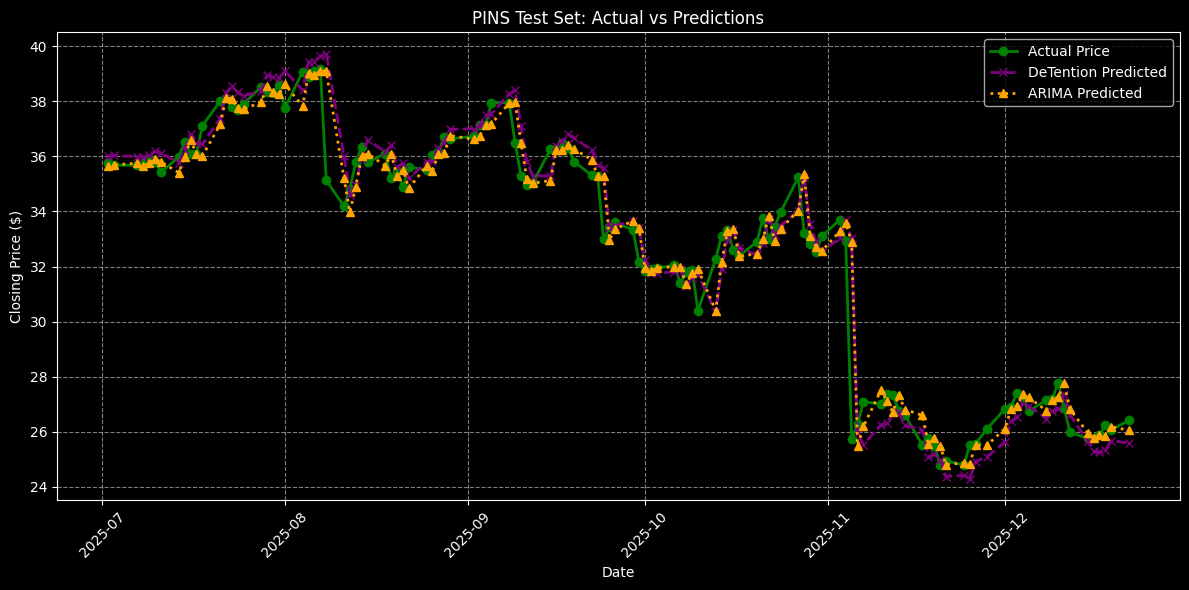

22/12/2025 19:41:37 - BackToTheTrainLogger (Train) - INFO - Test set comparison plot saved to models/PINS_test_comparison_plot.png


In [67]:
logger.info("Fitting ARIMA baseline for comparison")

# recompute series, train_series, test_series (since local in minmax_scale)
series = df['Close'].values.reshape(-1, 1)
split_idx = int(len(series) * train_ratio)
train_series = series[:split_idx].flatten()
test_series = series[split_idx:].flatten()

# fit ARIMA on original train_series (unscaled)
arima_order = (5, 1, 0)  # p,d,q
arima_model = ARIMA(train_series, order=arima_order)
arima_fit = arima_model.fit()

# ARIMA is autoregressive, so update with actuals
arima_predictions = []
history = list(train_series)
for t in range(len(test_series)):
    arima_temp = ARIMA(history, order=arima_order)
    arima_fit_temp = arima_temp.fit()
    forecast = arima_fit_temp.forecast()[0]
    arima_predictions.append(forecast)
    history.append(test_series[t])

# DeTention predictions on test set (unscaled)
model.eval()
detention_predictions = []
with torch.no_grad():
    for i in range(0, len(X_test_t), batch_size):
        batch_x = X_test_t[i:i + batch_size].to(device)
        batch_pred = model(batch_x).cpu().numpy()
        detention_predictions.extend(batch_pred)

detention_predictions = scaler.inverse_transform(np.array(detention_predictions).reshape(-1, 1)).flatten()
actual_test = test_series[L:]  # metrics (on original scale), align with windowed test set (skips first L in test)

arima_predictions_aligned = arima_predictions[L:]  # Align ARIMA to match
arima_mse = mean_squared_error(actual_test, arima_predictions_aligned)
arima_mae = mean_absolute_error(actual_test, arima_predictions_aligned)

detention_mse = mean_squared_error(actual_test, detention_predictions)
detention_mae = mean_absolute_error(actual_test, detention_predictions)

logger.info("ARIMA Test MSE: %.4f | MAE: %.4f", arima_mse, arima_mae)
logger.info("DeTention Test MSE: %.4f | MAE: %.4f", detention_mse, detention_mae)
logger.info("DeTention vs ARIMA: MSE Improvement: %.2f%% | MAE Improvement: %.2f%%",100 * (arima_mse - detention_mse) / arima_mse, 100 * (arima_mae - detention_mae) / arima_mae)

logger.info("Generating comparison plot for test set predictions")

dates = df.index  # get dates for test set (from original df)
test_start_idx = split_idx + L  # adjust for windowing offset
test_dates = dates[test_start_idx:test_start_idx + len(actual_test)]

plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(test_dates, actual_test, color='green', label='Actual Price', marker='o', linewidth=2)
ax.plot(test_dates, detention_predictions, color='purple', label='DeTention Predicted', marker='x', linewidth=2, linestyle='--')
ax.plot(test_dates, arima_predictions_aligned, color='orange', label='ARIMA Predicted', marker='^', linewidth=2, linestyle=':')
ax.set_title(f'{ticker} Test Set: Actual vs Predictions')
ax.set_xlabel('Date')
ax.set_ylabel('Closing Price ($)')
ax.legend()
ax.grid(True, linestyle='--', alpha=0.5)
plt.xticks(rotation=45)
plt.tight_layout()
plot_path = f"models/{ticker}_test_comparison_plot.png"
plt.savefig(plot_path)
plt.show()
plt.close()
logger.info("Test set comparison plot saved to %s", plot_path)

Looking at the results, ARIMA actually outperformed the DeTention model on this stock prediction task, achieving lower error metrics across both MSE and MAE. The plot shows both models tracking the general trends reasonably well, but ARIMA's predictions appear slightly closer to the actual prices overall. This outcome isn't entirely surprising - ARIMA models are specifically designed for time series forecasting and excel at capturing linear dependencies and autoregressive patterns in sequential data. While transformer-based architectures like DeTention can model complex non-linear relationships through attention mechanisms, stock prices often exhibit relatively simple temporal dependencies that classical statistical methods handle efficiently. The negative improvement percentages indicate DeTention performed about 22-24% worse than the baseline, suggesting that for this particular forecasting problem, the added complexity of the deep learning approach didn't translate to better predictions.